### (1) INCLUDING THE LIBRARIES NEEDED FOR THE CODE

In [239]:
import csv,re                         
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from random import shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

### (2) LOADING DATA AND SPLITTING DATA INTO TRAIN AND TEST
1. TOOK THE TAB DELIMITIED TEXT FILE AS INPUT
2. READ THE DOCUMENT LINE BY LINE
3. PARSED LINE BY LINE 
4. SPLIT THE DOCUMENT INTO TWO SETS(TRAINING AND TEST SET)
5. THE PERCENTAGE IS PROVIDED AS INPUT FOR SPLITTING (GENERALLY 80% CONSIDERED TRAINING DATA WHILE SPLITTING)
6. THE PREPROCESS AND THE FEATURE CONVERSION TAKES PLACE DURING SPLITTING (BY CALLING THEIR RESPECTIVE USER DEFINED FUNCTIONS)

In [240]:
# load data from a file and append it to the rawData
def loadData(path, Text=None):
    with open(path,encoding = "utf-8") as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "DOC_ID":  # skip the header
                continue
            (Id, Text, Label) = parseReview(line)
            rawData.append((Id, Text, Label))

def splitData(percentage):
    # A method to split the data between trainData and testData 
    dataSamples = len(rawData) 21000
    halfOfData = int(len(rawData)/2) 21000/2 = 10500

    trainingSamples = int((percentage*dataSamples)/2) .8 x 21000/2 = 8400
    
    for (_, Text, Label) in rawData[:trainingSamples] + rawData[halfOfData:halfOfData+trainingSamples]:
        trainData.append((toFeatureVector(preProcess(Text)),Label))
    for (_, Text, Label) in rawData[trainingSamples:halfOfData] + rawData[halfOfData+trainingSamples:]:
        testData.append((toFeatureVector(preProcess(Text)),Label))

### (3) PARSING DATA:
1. SPLIT INPUT INTO FOLLOWING PARTS:
    * DOC_ID
    * REVIEW_TEXT 
    * LABEL
2. THE LABEL FROM INPUT IS ASSIGNED VALUE AS PER THE REQUIRED OUTPUT CLASSES  <b>(<i>fake, real</i>)</b>
2. THE FUNCTION RETURNS A TUPLE <b>(<i>Id, Text, Label</i>)</b>

In [241]:
def parseReview(reviewLine):
    (Id, Text, Label) = (int(reviewLine[0]), reviewLine[8], fakeLabel if reviewLine[1]=='__label1__' else realLabel)
    return (Id, Text, Label)

### (4) MANUAL PREPROCESSING: (USING REGEX)
1. IDENTIFIED AND REMOVED THE HYPER LINKS, THE SPECIAL CHARACTERS, THE HTML TAGS
3. IDENTIFIED THE CONTRACTIONS AND REMOVED THE APOSTROPHE
5. REPLACED ALL THE SPECIAL CHARACTERS WITH WHITESPACES
6. CREATED TOKENS OF INDIVIDUAL WORDS
6. REMOVED NUMERIC DATA
7. REMOVED THE EMPTY ENTRIES, CREATED AS THE RESULT OF POINT 3, IN THE TOKEN LIST
8. CONVERTED ALL TOKENS TO LOWERCASE
9. THE FUNCTION RETURNS TOKEN LIST.

In [242]:
# TEXT PREPROCESSING AND FEATURE VECTORIZATION
spl_char = {}
hpr_link = {}
numbers = {}

# Input: a string of one review
def preProcess(text):# Should return a list of tokens
    hprlink = re.findall("http\S+",text) #find all hyperlink
    splchar = re.findall("\W",text) #find all special characters
    
    # Save the hyperlinks and special characters in dictionary for future analysis
    for h in hprlink:
        try:
            i = hpr_link[h]
        except KeyError:
            i = len(hpr_link) + 1
            hpr_link[h] = i            
    
    for s in splchar:
        try:
            i = spl_char[s]
        except KeyError:
            i = len(spl_char) + 1
            spl_char[s] = i

    # removing hyper link, html tags, hyphen in contraction, and other special characters inorder to tokenize
    text = re.sub(r"http\S+", "", text) 
    text = re.sub('<.*?>', '', text)
    text = re.sub(r"(\w)(['’])(\w)", r"\1\3", text) #contraction    
    
    # word tokenisation
    text = re.sub(r"\W", r" ", text)
    tokens = re.split(r"\s+",text)
    
    clean_tokens = []
    for token in tokens:
        if token.isnumeric() == False:
                 clean_tokens.append(token)
        else:
            try:
                i = numbers[token]
            except KeyError:
                i = len(numbers) + 1
                numbers[token] = i 
                
    #print(numbers)      
    # removing empty Strings
    clean_tokens = [token for token in clean_tokens if token] 
    
    # converting text to lower case 
    clean_tokens = [t.lower() for t in clean_tokens]

    return clean_tokens

### (5) CONVERTING THE TOKENS TO FEATURES

1.  THE GLOBAL DICTIONARY IS FILLED WITH THE FEATURES THAT ARE ENCOUNTERED DURING THE WHOLE FEATURE VECTOR CREATION PROCESS 
2.  THE  WEIGHING OF FEATURE IS BASED ON <b>(<i>1/No. of tokens per review</i>)</b>
3.  BOTH THE BINARY AND WEIGHTAGE ARE TRIED AND THE SUMMARY OF THE SAME PROVIDED AT THE END.

In [243]:
featureDict = {} # A global dictionary of features

def toFeatureVector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    
    localDict = {}
    for token in tokens:
        try:
            i = featureDict[token]
        except KeyError:
            i = len(featureDict) + 1
            featureDict[token] = i
        try:
            localDict[i] += (1.0/len(tokens))
        except KeyError:
            localDict[i] = (1.0/len(tokens))
            
    ###=======================================###
            ###### BINARY ###### 
    ###=======================================###
#    for token in tokens:
#        if token not in featureDict:
#            featureDict[token] = 1
#        else:
#            featureDict[token] = +1
            
#        if token not in localDict:
#            localDict[token] = 1
#        else:
#            localDict[token] = +1
            
    return localDict

### (6) TRAINING AND VALIDATING OUR CLASSIFIER

In [244]:
def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(trainData)

### (7) CROSS VALIDATING

1. THE 10 FOLD CROSS VALIDATION IS PERFORMED WHERE THE TRAINING DATA (80% OF THE WHOLE DATA) IS SPLIT IS 10 FOLDS AND EACH FOLD ACT AS TEST DATA AND THE REMAINING 10 FOLD ARE TRAINING DATA. 
4. THE MAIN CODE CALLS THE CROSS VALIDATE, WITH 80% OF THE MAIN DATASET, AND THE NUMBER OF FOLDS, AS PARAMETERS
2. THIS IS ACCOMPLISHED BY PUTTING THE FOLDS IN LOOP AND ROTATING THE FOLDS TO ACT AS TRAINING AND TEST DATA
3. THUS IT FOLLOWS THE PATTERN: 
    * TRAIN DATA: [:i]  
    * TEST DATA [i:foldSize+i] 
    * TRAIN DATA [foldSize+i:] 
    * COMBINED PROPERLY IN THE CODE WITH CONCATENATION 
3. THE CLASSIFIER IS PICKED FOR TRAINING AND VALIDATING
5. THE TEST DATA LABELS ARE GATHERED BEFORE PREDICTING ON THE TEST DATA
6. THE GATHERED(GROUND-TRUTH) LABELS AND PREDICTED LABELS ARE PASSED ON TO STANDARD FUNCTIONS TO IDENTIFY THE FOLLOWING:
    * PRECISON <b>(<i>sklearn.metrics.precision_recall_fscore_support()</i>)</b>
    * RECALL <b>(<i>sklearn.metrics.precision_recall_fscore_support()</i>)</b>
    * F-SCORE <b>(<i>sklearn.metrics.precision_recall_fscore_support()</i>)</b>
    * THE ABOVE VALUES RETURNED AS TUPLE BY THE FUNCTION
    * ACCURACY <b>(<i>sklearn.metrics.accuracy_score()</i>)</b>
7. THE AVERAGE OF EACH SCORE IS TAKEN USING MEAN 
8. FINAL RESULT IS RETURNED TO THE CALLING CODE

In [245]:
def crossValidate(dataset, folds):
    shuffle(dataset)
    foldSize = int(len(dataset)/folds)
    # DESCRIBE YOUR METHOD IN WORDS
    cv_results, precision, accuracy, recall,fbeta = ([] for i in range(5)) 
    for i in range(0,len(dataset),foldSize):     
        
        testData = dataset[i:foldSize+i]
        trainData = dataset[:i] + dataset[foldSize+i:] 


        #Fold 1 through 10 is picked in for each for loop   
              
        classifier = trainClassifier(trainData)
        #store the labels
        testTrue = [t[1] for t in testData]   #get the ground-truth labels from the data
        
        #classify the test data to get predicted labels
        testPred = predictLabels(testData,classifier)
        
        AS = accuracy_score(testTrue, testPred)
        (PC, RC, F1S,_) = precision_recall_fscore_support(testTrue, testPred, average='weighted') # evaluate
        
        precision.append(PC)
        recall.append(RC)
        fbeta.append(F1S)
        accuracy.append(AS)
        
        # F-Measure = (2 * Precision * Recall) / (Precision + Recall)
        # P = tp/(tp+fp)
        # R = tp/(tp+fn)
    cv_results = [sum(precision)/folds, sum(recall)/folds, sum(fbeta)/folds, sum(accuracy)/folds]
    return cv_results

In [246]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predictLabels(reviewSamples, classifier):
    return classifier.classify_many(map(lambda t: t[0], reviewSamples))

def predictLabel(reviewSample, classifier):
    return classifier.classify(toFeatureVector(preProcess(reviewSample)))

In [247]:
#### MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
rawData = []          # the filtered data from the dataset file (should be 21000 samples)
trainData = []        # the pre-processed training data as a percentage of the total dataset (currently 80%, or 16800 samples)
testData = []         # the pre-processed test data as a percentage of the total dataset (currently 20%, or 4200 samples)

# the output classes
fakeLabel = 'fake'
realLabel = 'real'

# references to the data files
reviewPath = 'amazon_reviews.txt'

# We parse the dataset and put it in a raw data list
print("Now %d Raw Data, %d Train Data, %d Test Data" % (len(rawData), len(trainData), len(testData)),
      "Preparing the dataset...",sep='\n')

print('\n')
loadData(reviewPath) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d Train Data, %d Test Data" % (len(rawData), len(trainData), len(testData)),
      "Preparing training and test data...",sep='\n')

splitData(0.8)

print('\n')
# We print the number of training samples and the number of features after the split
print("After split, %d Raw Data, %d Train Data, %d Test Data" % (len(rawData), len(trainData), len(testData)),'\n',
      "Training Samples: %d" % len(trainData), "Features: %d" % len(featureDict), sep='\n')

print('\n')

# QUESTION 3 - Make sure there is a function call here to the
# crossValidate function on the training set to get your results

print("K Fold cross-validation: ")
CV_Results= crossValidate(trainData, 10)
print('\n')
print(
      "Precision:", CV_Results[0],
      ", Recall:", CV_Results[1],
      ", F Score", CV_Results[2],
      ", Accuracy:", CV_Results[3])
    

Now 0 Raw Data, 0 Train Data, 0 Test Data
Preparing the dataset...


Now 21000 rawData, 0 Train Data, 0 Test Data
Preparing training and test data...


After split, 21000 Raw Data, 16800 Train Data, 4200 Test Data


Training Samples: 16800
Features: 35179


K Fold cross-validation: 
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...


Precision: 0.6469652540209123 , Recall: 0.6458928571428572 , F Score 0.6454233268401051 , Accuracy: 0.6458928571428572


### (8) EVALUATE ON TEST DATA

In [248]:
# Finally, check the accuracy of your classifier by training on all the tranin data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(testData[0])  # have a look at the first test data instance
    print('\n')
    finalScores = []
    classifier = trainClassifier(trainData)  # train the classifier
    testTrue = [t[1] for t in testData]   # get the ground-truth labels from the data
    testPred = predictLabels(testData, classifier)  # classify the test data to get predicted labels
    accuracy = accuracy_score(testTrue, testPred)
    (precision,recall,fbeta,_) = precision_recall_fscore_support(testTrue, testPred, average='weighted') # evaluate
    
    finalScores.append(precision)
    finalScores.append(recall)
    finalScores.append(fbeta)
    finalScores.append(accuracy)
    

    print('\n')
    print("Done training!")
    print('\n')
    print('\t',"Precision:", finalScores[0],'\n',
          '\t',"Recall:", finalScores[1],'\n',
          '\t',"F Score", finalScores[2],'\n',
          '\t',"Accuracy:", finalScores[3])

({6: 0.09523809523809523, 3902: 0.047619047619047616, 31: 0.047619047619047616, 196: 0.047619047619047616, 20254: 0.047619047619047616, 45: 0.047619047619047616, 56: 0.047619047619047616, 44: 0.047619047619047616, 10: 0.09523809523809523, 115: 0.047619047619047616, 612: 0.047619047619047616, 23: 0.047619047619047616, 1421: 0.047619047619047616, 1131: 0.047619047619047616, 721: 0.047619047619047616, 1609: 0.047619047619047616, 1598: 0.047619047619047616, 138: 0.047619047619047616, 90: 0.047619047619047616}, 'fake')


Training Classifier...


Done training!


	 Precision: 0.629317866998244 
 	 Recall: 0.6290476190476191 
 	 F Score 0.6288537140492447 
 	 Accuracy: 0.6290476190476191


### (9) SUMMARIZING



toFeatureVector,Stage,Precision,Recall,F-Score,Accuracy
Binary,Training,0.6050831669425428,0.6048214285714286,0.6045655786836039,0.6048214285714286
Binary,Testing,0.5859539596985796,0.585952380952381,0.5859504797045837,0.585952380952381
Weighed,Training,0.6492461085573931,0.6483928571428571,0.6479372380917668,0.6483928571428571
Weighed,Testing,0.629317866998244,0.6290476190476191,0.6288537140492447,0.6290476190476191


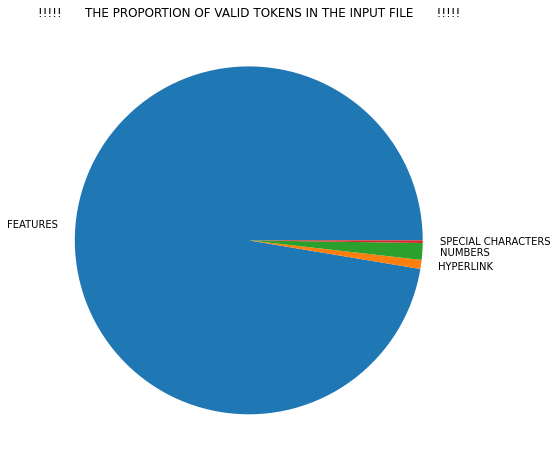



--------------------------------------!!! 😞 WE ARE KICKED OUT DURING PREPROCESSING 😞 !!!------------------------------------

 {' ': 1, ',': 2, '.': 3, "'": 4, '<': 5, '/': 6, '>': 7, '?': 8, '!': 9, '[': 10, ':': 11, '-': 12, ']': 13, '(': 14, ')': 15, '$': 16, '&': 17, ';': 18, '#': 19, '"': 20, '’': 21, '%': 22, '*': 23, '~': 24, '=': 25, '+': 26, '–': 27, '@': 28, '—': 29, '{': 30, '}': 31, '😖': 32, '”': 33, '“': 34, '\u200f': 35, '\\': 36, '`': 37, '…': 38, '，': 39, '®': 40, '‘': 41, '\u200b': 42, '|': 43, '☆': 44, '™': 45, '：': 46, '😀': 47, '。': 48, '^': 49, '😊': 50, '👏': 51, '´': 52, '！': 53, '¬': 54, '★': 55, '\xa0': 56, '🎥': 57, '✅': 58, '🍅': 59, '◆': 60, '▪': 61, '″': 62, '·': 63, '�': 64, '👌': 65, '¡': 66, '🐈': 67, '💞': 68, '😆': 69, '😍': 70, '👍': 71, '💖': 72, '💗': 73, '°': 74, '†': 75, '😉': 76, '¯': 77, '💜': 78, '×': 79, '😘': 80, '±': 81, '▶': 82, '•': 83, '∙': 84, '\x1a': 85, '¢': 86, '😞': 87}


 and also the 301 Hyperlinks !!! ......along with 563 numbers!!!!!




In [249]:
print('\n')
from IPython.display import HTML, display
data = [["toFeatureVector", "Stage", "Precision", "Recall", "F-Score", "Accuracy"],
        ["Binary","Training","0.6050831669425428","0.6048214285714286","0.6045655786836039","0.6048214285714286"],
        ["Binary","Testing","0.5859539596985796","0.585952380952381","0.5859504797045837", "0.585952380952381"],
        ["Weighed","Training","0.6492461085573931","0.6483928571428571","0.6479372380917668","0.6483928571428571"],
        ["Weighed","Testing","0.629317866998244","0.6290476190476191","0.6288537140492447","0.6290476190476191"]
        ]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

from matplotlib import pyplot as plt 
import numpy as np 

# Creating plot 
proportion = ['FEATURES', 'HYPERLINK', "NUMBERS", 'SPECIAL CHARACTERS'] 
  
data = [len(featureDict), len(hpr_link), len(numbers),len(spl_char)] 

# Creating plot 
fig = plt.figure(figsize =(10, 8)) 
plt.pie(data, labels = proportion)
plt.title("!!!!!      THE PROPORTION OF VALID TOKENS IN THE INPUT FILE      !!!!!") 
# show plot 
plt.show() 

print('\n')
print("--------------------------------------!!! 😞 WE ARE KICKED OUT DURING PREPROCESSING 😞 !!!------------------------------------")
print('\n', spl_char)
print('\n')
print(" and also the" , len(hpr_link), "Hyperlinks !!!", "......along with", len(numbers), "numbers!!!!!")
print('\n')